# Notebook to generate synthetic eye-tracking data for reading

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import sys
import joblib
import seaborn as sns
import pandas as pd
from typing import Dict
from typing import List
from typing import Tuple
from matplotlib import image
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")





import tensorflow
import tensorflow as tf
from sp_eyegan.model import eventGAN as eventGAN

%pylab inline
%load_ext autoreload
%autoreload 2

In [2]:
def vel_to_dva(vel_data, x_start = 0,
             y_start = 0):
    x_vel = vel_data[:,0]
    y_vel = vel_data[:,1]
    x_px  = []
    y_px  = []
    cur_x_pos = x_start
    cur_y_pos = y_start
    for i in range(len(x_vel)):
        x_px.append(cur_x_pos + x_vel[i])
        y_px.append(cur_y_pos + y_vel[i])
        cur_x_pos = x_px[-1]
        cur_y_pos = y_px[-1]
    return np.concatenate([np.expand_dims(np.array(x_px),axis=1),
                           np.expand_dims(np.array(y_px),axis=1)],axis=1)


def draw_display(dispsize: Tuple[int, int], imagefile=None) -> Tuple[pyplot.figure, pyplot.Axes]:
    # construct screen (black background)
    # dots per inch
    img = image.imread(imagefile)
    dpi = 100.0
    # determine the figure size in inches
    figsize = (dispsize[0]/dpi, dispsize[1]/dpi)
    # create a figure
    fig = pyplot.figure(figsize=figsize, dpi=dpi, frameon=False)
    ax = pyplot.Axes(fig, [0, 0, 1, 1])
    ax.set_axis_off()
    fig.add_axes(ax)
    # plot display
    ax.axis([0, dispsize[0], 0, dispsize[1]])
    ax.imshow(img)

    return fig, ax



def pix2deg(pix, screenPX,screenCM,distanceCM, adjust_origin=True):
    # Converts pixel screen coordinate to degrees of visual angle
    # screenPX is the number of pixels that the monitor has in the horizontal
    # axis (for x coord) or vertical axis (for y coord)
    # screenCM is the width of the monitor in centimeters
    # distanceCM is the distance of the monitor to the retina 
    # pix: screen coordinate in pixels
    # adjust origin: if origin (0,0) of screen coordinates is in the corner of the screen rather than in the center, set to True to center coordinates
    pix=np.array(pix)
    # center screen coordinates such that 0 is center of the screen:
    if adjust_origin: 
        pix = pix-(screenPX)/2 # pixel coordinates start with (0,0) 
    # eye-to-screen-distance in pixels of screen
    distancePX = distanceCM*(screenPX/screenCM)
    return np.arctan2(pix,distancePX) * 180/np.pi #  *180/pi wandelt bogenmass in grad


def deg2pix(deg, screenPX, screenCM, distanceCM, adjust_origin = True, offsetCM = 0):
    # Converts degrees of visual angle to pixel screen coordinates
    # screenPX is the number of pixels that the monitor has in the horizontal
    # screenCM is the width of the monitor in centimeters
    # distanceCM is the distance of the monitor to the retina 
    phi = np.arctan2(1,distanceCM)*180/np.pi
    pix = deg/(phi/(screenPX/(screenCM)))
    if adjust_origin:
        pix += (screenPX/2)
    if offsetCM != 0:
        offsetPX = offsetCM*(screenPX/screenCM)
        pix += offsetPX
    return pix

In [3]:
def sample_fix_duraton_prob(word):
    word_len = len(word)
    if word_len == 1:
        prob = 0.077
        duration = 209
    elif word_len == 2:
        prob = 0.205
        duration = 215
    elif word_len == 3:
        prob = 0.318
        duration = 210
    elif word_len == 4:
        prob = 0.48
        duration = 205
    elif word_len == 5:
        prob = 0.8
        duration = 229
    elif word_len == 6:
        prob = 0.825
        duration = 244
    elif word_len == 7:
        prob = 0.875
        duration = 258
    elif word_len == 8:
        prob = 0.915
        duration = 260
    elif word_len >= 9:
        prob = 0.94
        duration = 276
    return (prob, duration)

def sample_postions_for_text(text):
    x_locations = []
    y_locations = []
    fix_durations = []
    for i in range(len(text)):
        word,x_pos,y_pos = text[i]
        prob, duration = sample_fix_duraton_prob(word)
        # choice
        choice = np.random.choice([0,1],size=(1,),p=[1-prob,prob])[0]
        if choice == 1:
            x_locations.append(x_pos)
            y_locations.append(y_pos)
            fix_durations.append(duration)
    return np.array(x_locations), np.array(y_locations), np.array(fix_durations)

### Parameter settings

In [4]:
# params
GPU = -1                      # specify the GPU number, or -1 if you want to run everything on CPU
model_dir = 'event_model/'   # specify the location of the saved model for FixGAN and SacGAN
data_dir = 'sample_data/'    # specify the folder where the sample data is located

In [5]:
if GPU != -1:
    flag_train_on_gpu = True
else:
    flag_train_on_gpu = False
    
if flag_train_on_gpu:
    import tensorflow as tf
    # select graphic card
    os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    config = tf.compat.v1.ConfigProto(log_device_placement=True)
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    tf_session = tf.compat.v1.Session(config=config)
else:
    import tensorflow as tf
    # select graphic card
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [6]:
# params for NN
random_size = 32
fix_window_size = 100
window_size = 100
sac_window_size = 30
gen_kernel_sizes_fixation = [fix_window_size,8,4,2]
gen_kernel_sizes_saccade = [sac_window_size,8,4,2]
gen_filter_sizes = [16,8,4,2]
channels = 2
relu_in_last = False
batch_size = 256

dis_kernel_sizes = [8,16,32]
dis_fiter_sizes = [32,64,128]
dis_dropout = 0.3

sample_size = 1000



# params for generator
channels = 2
mean_sacc_len = 20
std_sacc_len  = 10

mean_fix_len  = 250
std_fix_len   = 225

stimulus = 'text'


fixation_path  = model_dir + 'fixation_model_' + stimulus
saccade_path   = model_dir + 'saccade_model_' + stimulus 

model_config_fixation = {'gen_kernel_sizes':gen_kernel_sizes_fixation,
                'gen_filter_sizes':gen_filter_sizes,
                'dis_kernel_sizes':dis_kernel_sizes,
                'dis_fiter_sizes':dis_fiter_sizes,
                'dis_dropout':dis_dropout,
                'window_size':fix_window_size,
                'channels':channels,
                'batch_size':batch_size,
                'random_size':random_size,
                'relu_in_last':relu_in_last,
               }

model_config_saccade = {'gen_kernel_sizes':gen_kernel_sizes_saccade,
                'gen_filter_sizes':gen_filter_sizes,
                'dis_kernel_sizes':dis_kernel_sizes,
                'dis_fiter_sizes':dis_fiter_sizes,
                'dis_dropout':dis_dropout,
                'window_size':sac_window_size,
                'channels':channels,
                'batch_size':batch_size,
                'random_size':random_size,
                'relu_in_last':relu_in_last,
               }

gan_config = {'window_size':window_size,
              'random_size':random_size,
              'channels':channels,
              'mean_sacc_len':mean_sacc_len,
              'std_sacc_len':std_sacc_len,
              'mean_fix_len':mean_fix_len,
              'std_fix_len':std_fix_len,
              'fixation_path':fixation_path,
              'saccade_path':saccade_path,
             }

In [7]:
data_generator = eventGAN.dataGenerator(gan_config,
                                        model_config_fixation,
                                        model_config_saccade,
                                       )

2023-08-18 15:14:21.289733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
ocr_data = pd.read_csv(data_dir + '/TEX_R5S1_bg.csv')
ocr_data.head()

,Unnamed: 0,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,0,1,1,0,0,0,0,0,0,1680,1050,-1,NaN
1,1,2,1,1,0,0,0,655,8,370,25,-1,NaN
2,2,3,1,1,1,0,0,655,8,370,25,-1,NaN
3,3,4,1,1,1,1,0,655,8,370,25,-1,NaN
4,4,5,1,1,1,1,1,655,8,57,19,96,THE


In [9]:
expt_txt = {  'px_x':1680,
              'px_y':1050,
              'max_dva_x': 30,
              'max_dva_y': 25
             }

In [10]:
confs = np.array(ocr_data['conf'])
lefts = np.array(ocr_data['left'])
tops = np.array(ocr_data['top'])
widths = np.array(ocr_data['width'])
heights = np.array(ocr_data['height'])
words = np.array(ocr_data['text'])

text_list = []

for i in range(len(confs)):
    cur_conf = confs[i]
    if cur_conf != -1:        
        text_list.append((words[i],
                          lefts[i] + (widths[i]/2),
                        tops[i] + (heights[i]/2)))

x_locations, y_locations, fix_durations = sample_postions_for_text(text_list)
x_dva = x_locations / expt_txt['px_x'] * expt_txt['max_dva_x']
y_dva = y_locations / expt_txt['px_y'] * expt_txt['max_dva_y']

## Scanpath generation
* you can increase the quality by higher numbers of num_sample_saccs

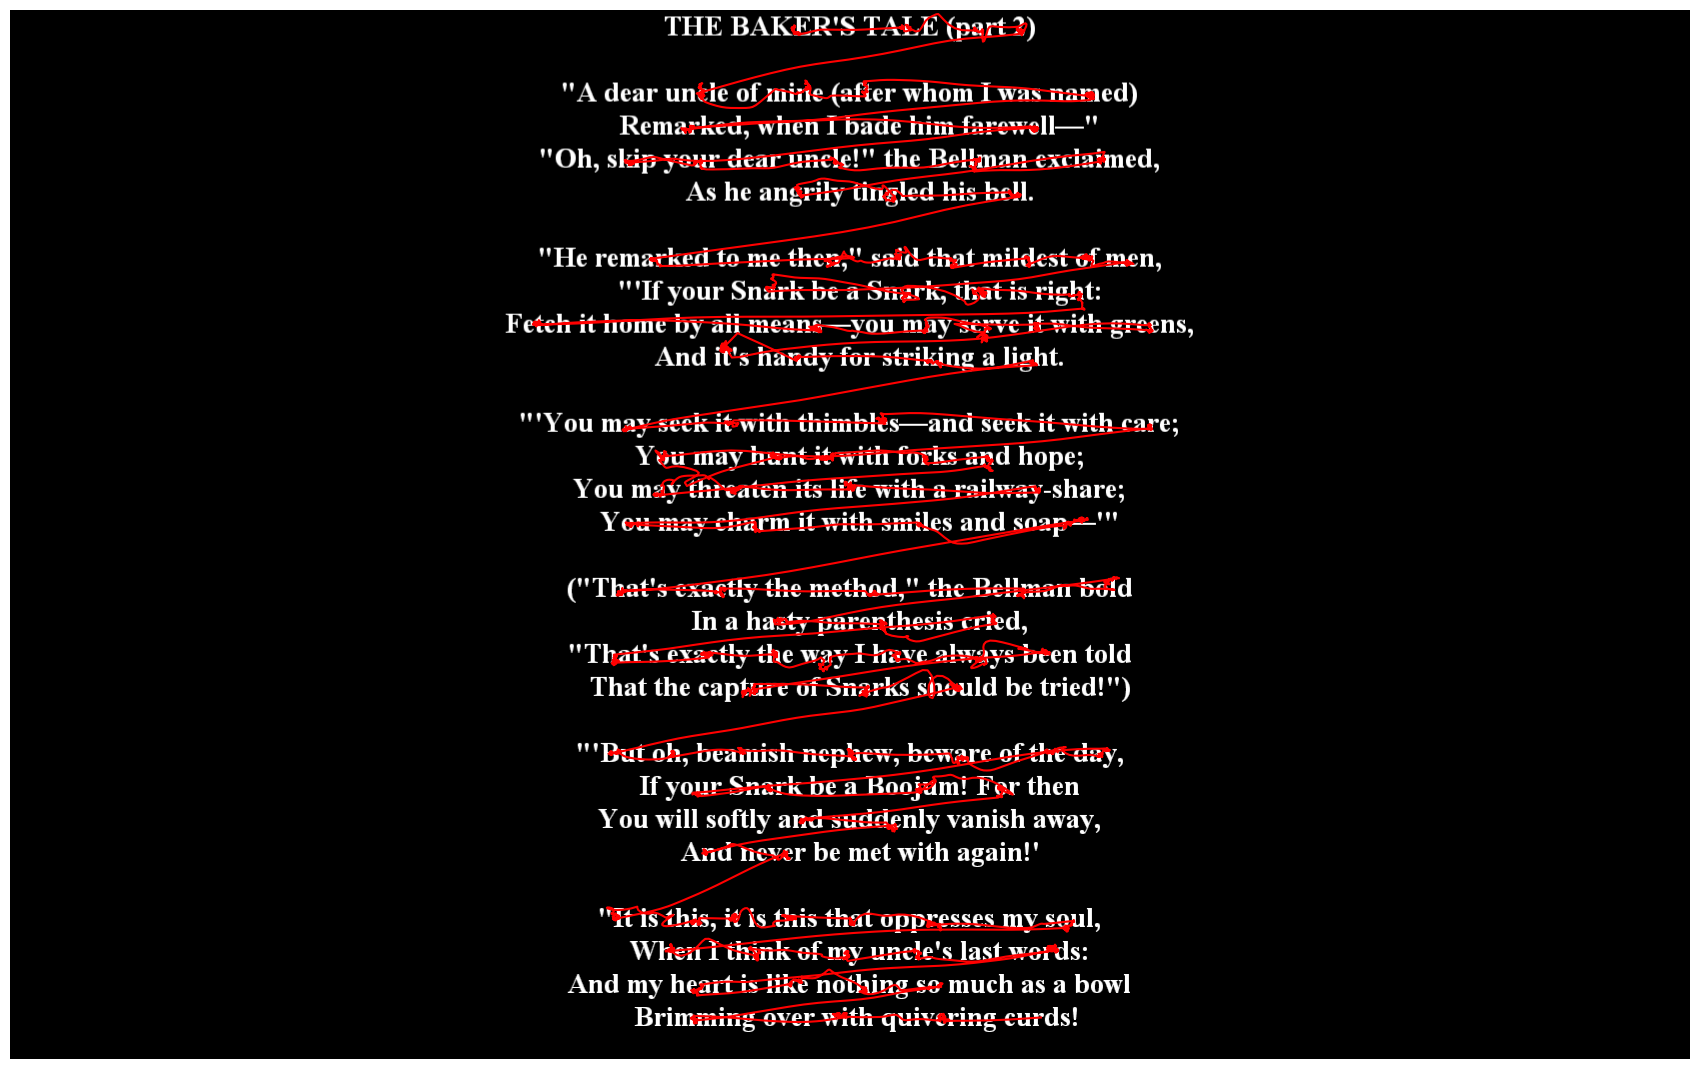

In [11]:
image_path = data_dir + 'TEX_R5S1_bg.png'
    
x_locations_in, y_locations_in, fix_durations = sample_postions_for_text(text_list)
x_dva = x_locations_in / expt_txt['px_x'] * expt_txt['max_dva_x']
y_dva = y_locations_in / expt_txt['px_y'] * expt_txt['max_dva_y']

x_locations, y_locations = data_generator.sample_scanpath(
                        x_fix_locations = x_dva,
                        y_fix_locations = y_dva,
                        num_sample_saccs = 1000,
                        dva_threshold = 0.01,
                        fixation_durations = fix_durations,
                        saccade_durations = None,
                       )
fig, ax = draw_display(dispsize=(1680, 1050), imagefile=image_path)    

ax.plot(np.array(x_locations)/expt_txt['max_dva_x'] * expt_txt['px_x'],
        np.array(y_locations)/expt_txt['max_dva_y'] * expt_txt['px_y'],'r-')
 
ax.invert_yaxis()
plt.show()